## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Lipinski as l
import rdkit.Chem.Fragments as f
from rdkit.Chem import Descriptors
import rdkit.Chem.rdMolDescriptors as d

from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

## Extract features from SMILES

In [2]:
def binaryToInt(list):
  return int("".join(str(i) for i in list),2)

def aromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  return np.sum([1 if i == True else 0 for i in aromatic_atoms])

# Append all feature values to a list
def getFeatureValsForM(m):
  features = []
  features.append(f.fr_halogen(m))
  features.append(f.fr_Al_COO(m))
  features.append(l.NHOHCount(m))
  features.append(l.NumHAcceptors(m))
  features.append(l.NumHDonors(m))
  features.append(l.NumHeteroatoms(m))
  features.append(l.NumAliphaticRings(m))
  features.append(l.HeavyAtomCount(m))
  features.append(Descriptors.MolLogP(m))
  features.append(Descriptors.MolWt(m))
  features.append(Descriptors.NumRotatableBonds(m))
  features.append(aromaticAtoms(m))
  features.append(aromaticAtoms(m)/Descriptors.HeavyAtomCount(m))
  fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=124)
  features.append(binaryToInt(fp))
  return features

# Extract features and add it to DF
def extractFeatures(raw_data):
  data = []
  for smile in raw_data['SMILES']:
    m = Chem.MolFromSmiles(smile)
    feature_vals = getFeatureValsForM(m)
    columns = ['x' + str(i + 1) for i in range(len(feature_vals))]
    data.append(dict(zip(columns, feature_vals)))
  return pd.DataFrame(data)

def plotROCAUC(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  model.fit(X_train, y_train)
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print('AUC score on train/test split: ' + str(roc_auc))

def testModel(model, X, y):
  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='roc_auc')
  print(str(score) + ' Average AUC: ' + str(round(np.mean(score), 4)) + ', STD: ' + str(round(np.std(score), 4)))
  plotROCAUC(model, X, y)
  
def tuneModel(model, params_grid, X, y):
  print('Vanilla model')
  testModel(model, X, y)

  strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  grid_search = GridSearchCV(model, param_grid=params_grid, cv=strat_k_fold, scoring='roc_auc')
  grid_search.fit(X, y)
  best_params = grid_search.best_params_
  model.set_params(**best_params)
  
  print('Tuned model with params: ' + str(best_params))
  testModel(model, X, y)


## Read the splitted training data (new_training_smiles.csv)

In [3]:
raw_data = pd.read_csv('new_training_smiles.csv')
raw_data.drop('Unnamed: 0', axis=1, inplace=True)
display(raw_data)

,SMILES,ACTIVE
0,C=C(C)c1cccc(C(C)(C)NC(=O)Nc2cc(C)ccc2OC)c1,0.0
1,CCOC(=O)c1cnn2c(C(F)(F)F)cc(-c3cn(C)nc3C)nc12,0.0
2,COc1ccccc1-n1cnc2cc(NC(=O)c3ccco3)ccc21,0.0
3,COc1c(CO)cc(CO)cc(CO)c1=O,0.0
4,COC(=O)CN1C(=S)N(c2ccc(OC)cc2)C(=O)/C1=C/c1cccs1,0.0
...,...,...
133704,c1ccc(Cn2ccnc2-c2ccco2)cc1,0.0
133705,CCOC(=O)c1cnc2c(-c3ccc(Cl)cc3)cnn2c1C,0.0
133706,COc1cc(C(=O)Oc2cccc(C)c2)cc(OC)c1OC,0.0
133707,CC(=O)Nc1cc2c(cc1C(=O)C(C)C)OCCO2,0.0


## Transform data (extract features)

In [4]:
y = [int(label) for label in raw_data['ACTIVE'].values]
raw_data.drop(['ACTIVE'], axis=1, inplace=True)
X = extractFeatures(raw_data)
display(X)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0,0,2,2,2,4,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,3,0,0,7,0,10,0,25,2.63372,353.304,3,14,0.560000,4476816478950354051105503996738056205
2,0,0,1,5,1,6,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
3,0,0,3,5,3,5,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
4,0,0,0,6,0,8,1,26,2.90430,388.470,5,11,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133704,0,0,0,3,0,3,0,17,3.19140,224.263,3,16,0.941176,607503884757588786199083587247138058
133705,1,0,0,5,0,6,0,22,3.53482,315.760,3,15,0.681818,623168840203088061610875933794848774
133706,0,0,0,5,0,5,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
133707,0,0,1,4,1,5,1,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


## Investigate the correlation of the features

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
x1,1.000000,-0.032307,-0.021812,-0.147089,-0.015053,0.251643,-0.092956,0.034341,0.222413,0.149373,-0.066129,0.017636,0.000669
x2,-0.032307,1.000000,0.211567,-0.034055,0.228485,0.028414,0.010610,-0.025880,-0.120934,-0.020056,0.097784,-0.149297,-0.153286
x3,-0.021812,0.211567,1.000000,0.139462,0.960397,0.292244,-0.045853,0.120099,-0.282112,0.138193,0.200072,-0.111495,-0.165579
x4,-0.147089,-0.034055,0.139462,1.000000,0.114529,0.790075,0.071005,0.571088,-0.198729,0.577248,0.417408,0.297890,0.020260
x5,-0.015053,0.228485,0.960397,0.114529,1.000000,0.297271,-0.040220,0.150845,-0.244470,0.168668,0.233579,-0.104366,-0.178230
x6,0.251643,0.028414,0.292244,0.790075,0.297271,1.000000,0.052795,0.644850,-0.173802,0.721878,0.462688,0.220045,-0.115837
x7,-0.092956,0.010610,-0.045853,0.071005,-0.040220,0.052795,1.000000,0.279267,-0.073855,0.247432,-0.142873,-0.340363,-0.539537
x8,0.034341,-0.025880,0.120099,0.571088,0.150845,0.644850,0.279267,1.000000,0.347502,0.962525,0.600815,0.503828,-0.005451
x9,0.222413,-0.120934,-0.282112,-0.198729,-0.244470,-0.173802,-0.073855,0.347502,1.000000,0.342056,0.137291,0.513783,0.366947
x10,0.149373,-0.020056,0.138193,0.577248,0.168668,0.721878,0.247432,0.962525,0.342056,1.000000,0.604837,0.447957,-0.045258


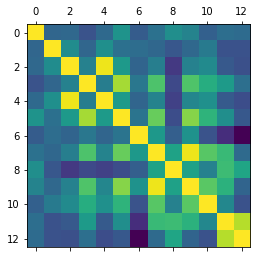

In [5]:
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Conclusions of investigation of correlation of features
x3 and x5 are highly correlated <br />
x8 and x10 are highly correlated <br />
x12 and x13 are highly correlated <br />
**Conclusion: Drop x3, x8 and x12**

In [5]:
X.drop(['x3', 'x8', 'x12'], axis=1, inplace=True)

,x1,x2,x4,x5,x6,x7,x9,x10,x11,x13,x14
0,0,0,2,2,4,0,5.09352,338.451,5,0.480000,5671210215184166703700378702203336722
1,3,0,7,0,10,0,2.63372,353.304,3,0.560000,4476816478950354051105503996738056205
2,0,0,5,1,6,0,3.87940,333.347,4,0.800000,523695094110335032410745669696142338
3,0,0,5,3,5,0,-0.46770,226.228,4,0.437500,21357387526891337304840442166116352
4,0,0,6,0,8,1,2.90430,388.470,5,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...,...,...
133704,0,0,3,0,3,0,3.19140,224.263,3,0.941176,607503884757588786199083587247138058
133705,1,0,5,0,6,0,3.53482,315.760,3,0.681818,623168840203088061610875933794848774
133706,0,0,5,0,5,0,3.24002,302.326,5,0.545455,1682720011216148433928110003258920962
133707,0,0,4,1,5,1,2.25490,263.293,3,0.315789,5743091227781309622800876834866108448


,x1,x2,x4,x5,x6,x7,x9,x10,x11,x13
x1,1.000000,-0.032307,-0.147089,-0.015053,0.251643,-0.092956,0.222413,0.149373,-0.066129,0.000669
x2,-0.032307,1.000000,-0.034055,0.228485,0.028414,0.010610,-0.120934,-0.020056,0.097784,-0.153286
x4,-0.147089,-0.034055,1.000000,0.114529,0.790075,0.071005,-0.198729,0.577248,0.417408,0.020260
x5,-0.015053,0.228485,0.114529,1.000000,0.297271,-0.040220,-0.244470,0.168668,0.233579,-0.178230
x6,0.251643,0.028414,0.790075,0.297271,1.000000,0.052795,-0.173802,0.721878,0.462688,-0.115837
x7,-0.092956,0.010610,0.071005,-0.040220,0.052795,1.000000,-0.073855,0.247432,-0.142873,-0.539537
x9,0.222413,-0.120934,-0.198729,-0.244470,-0.173802,-0.073855,1.000000,0.342056,0.137291,0.366947
x10,0.149373,-0.020056,0.577248,0.168668,0.721878,0.247432,0.342056,1.000000,0.604837,-0.045258
x11,-0.066129,0.097784,0.417408,0.233579,0.462688,-0.142873,0.137291,0.604837,1.000000,-0.150768
x13,0.000669,-0.153286,0.020260,-0.178230,-0.115837,-0.539537,0.366947,-0.045258,-0.150768,1.000000


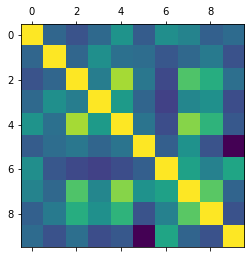

In [7]:
display(X)
display(X.corr())
plt.matshow(X.corr())
plt.show()

## Look at feature importance

[0.01773165 0.00083584 0.05569649 0.04264518 0.05470212 0.0238395
 0.17833808 0.17635018 0.0648386  0.13419598 0.25082639]


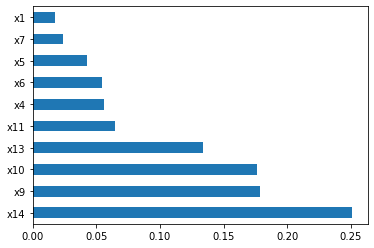

In [8]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

**Conclusions: drop x1 and x7**

In [6]:
X.drop(['x1', 'x7'], axis=1, inplace=True)

In [18]:
display(X)

,x2,x4,x5,x6,x9,x10,x11,x13,x14
0,0,2,2,4,5.09352,338.451,5,0.480000,5671210215184166703700378702203336722
1,0,7,0,10,2.63372,353.304,3,0.560000,4476816478950354051105503996738056205
2,0,5,1,6,3.87940,333.347,4,0.800000,523695094110335032410745669696142338
3,0,5,3,5,-0.46770,226.228,4,0.437500,21357387526891337304840442166116352
4,0,6,0,8,2.90430,388.470,5,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...
133704,0,3,0,3,3.19140,224.263,3,0.941176,607503884757588786199083587247138058
133705,0,5,0,6,3.53482,315.760,3,0.681818,623168840203088061610875933794848774
133706,0,5,0,5,3.24002,302.326,5,0.545455,1682720011216148433928110003258920962
133707,0,4,1,5,2.25490,263.293,3,0.315789,5743091227781309622800876834866108448


## Test vanilla models

### Bernoulli Naive Bayes classifier

StandardScaler
[0.78862893 0.70427155 0.71961536 0.75265171 0.86586902 0.76452273
 0.78701639 0.78964639 0.75483221 0.7807817 ] Average AUC: 0.7708, STD: 0.0421


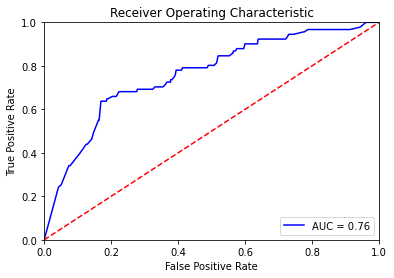

AUC score on train/test split: 0.7606301218953827
MinMaxScaler
[0.56616448 0.58101387 0.52188081 0.5682448  0.57225937 0.59419249
 0.51897251 0.53895459 0.52017509 0.52619341] Average AUC: 0.5508, STD: 0.0271


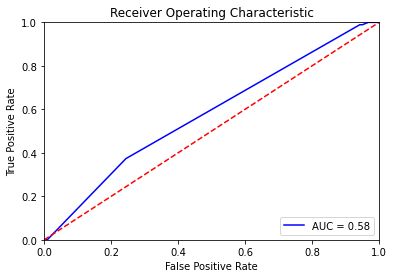

AUC score on train/test split: 0.5769459864909365


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 2 bins
[0.78863879 0.70512421 0.72162955 0.75781006 0.86166694 0.76840408
 0.78608774 0.78698974 0.74167224 0.76503802] Average AUC: 0.7683, STD: 0.041


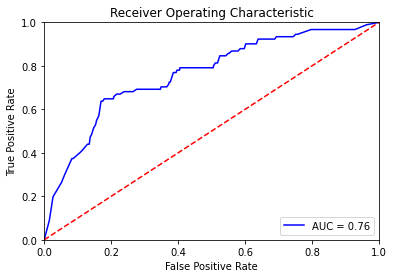

AUC score on train/test split: 0.761532330344761


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 4 bins
[0.78510088 0.70961544 0.73546444 0.77503977 0.87395935 0.78954671
 0.80886858 0.81337856 0.73904217 0.76888906] Average AUC: 0.7799, STD: 0.0443


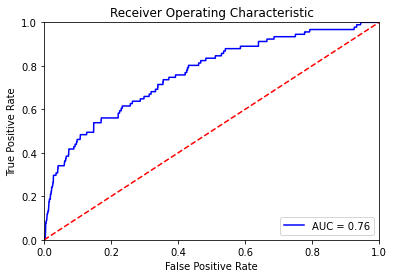

AUC score on train/test split: 0.7629631070252602


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 8 bins
[0.77574538 0.70595416 0.74395248 0.77135284 0.8661335  0.78538904
 0.80503756 0.81150154 0.74305027 0.77645988] Average AUC: 0.7785, STD: 0.0416


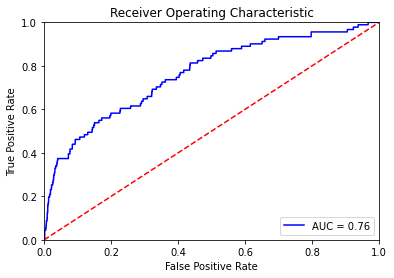

AUC score on train/test split: 0.7622042893962984


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 16 bins
[0.76892613 0.71296289 0.75310074 0.78886775 0.86300513 0.78867037
 0.81152029 0.81349896 0.75950383 0.78919142] Average AUC: 0.7849, STD: 0.0384


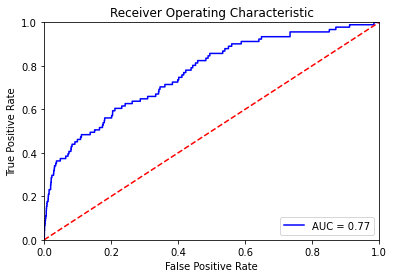

AUC score on train/test split: 0.766653525255079


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.77513155 0.71212701 0.75800941 0.79476329 0.87412514 0.79176716
 0.82249819 0.81013966 0.76628336 0.79698134] Average AUC: 0.7902, STD: 0.0406


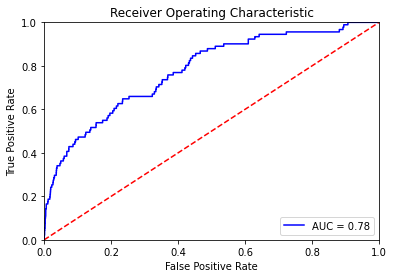

AUC score on train/test split: 0.7780888607747654


In [13]:
# --- Discretization 32 bins is best! ---

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(BernoulliNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(BernoulliNB(), X_cop, y)

Bernoulli Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Gaussian Naive Bayes classifier

StandardScaler
[0.76981332 0.72170949 0.74435808 0.77847209 0.86556309 0.82571242
 0.8104071  0.79391458 0.76501496 0.78151105] Average AUC: 0.7856, STD: 0.039


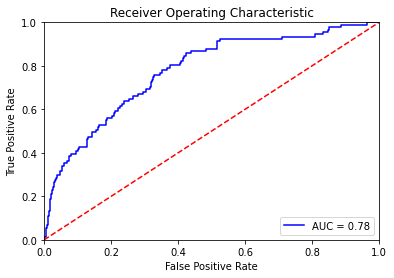

AUC score on train/test split: 0.7753817409755257


In [14]:
testModel(GaussianNB(), X, y)

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(GaussianNB(), X_cop, y)

# --- Standard and MinMax scaler yields the same result! ---

# X_cop = X.copy()
# sc = MinMaxScaler()
# X_cop = sc.fit_transform(X_cop)
# print('MinMaxScaler')
# testModel(GaussianNB(), X_cop, y)

# --- This crashes! ---

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization')
# testModel(GaussianNB(), X_cop, y)

Gaussian Naive Bayes classifier best preprocessing = standard or minmax scaler (Average AUC: 0.7969, STD: 0.0246, AUC score on train/test split: 0.784)

### Multinomial Naive Bayes classifier

MinMaxScaler
[0.79028884 0.74005929 0.75055166 0.78974606 0.85076008 0.79328595
 0.82758451 0.75178919 0.73381954 0.79587103] Average AUC: 0.7824, STD: 0.0364


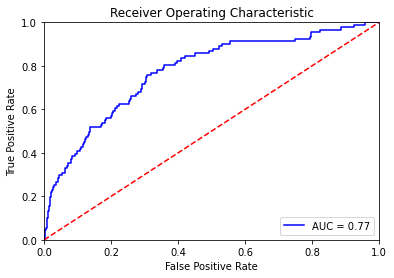

AUC score on train/test split: 0.7735535904237347


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 2 bins
[0.78863879 0.70512421 0.72162955 0.75781006 0.86166694 0.76840408
 0.78608774 0.78698974 0.74167224 0.76503802] Average AUC: 0.7683, STD: 0.041


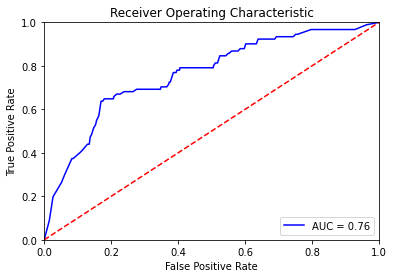

AUC score on train/test split: 0.761532330344761


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Discretization 4 bins
[0.78801608 0.71189707 0.73706316 0.77691284 0.87401264 0.78846905
 0.80970544 0.8098515  0.74196554 0.77050172] Average AUC: 0.7808, STD: 0.0433


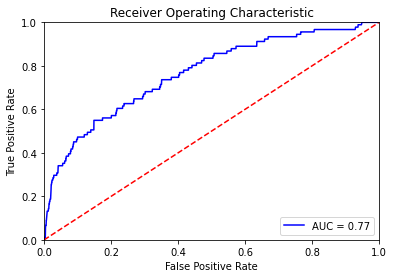

AUC score on train/test split: 0.7652194522338807


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 8 bins
[0.77731055 0.70756473 0.74558278 0.77145744 0.86686378 0.7859555
 0.80583297 0.81308842 0.74595825 0.77763237] Average AUC: 0.7797, STD: 0.0413


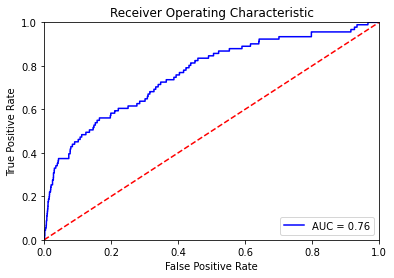

AUC score on train/test split: 0.7639731058155032


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 16 bins
[0.77137356 0.71446293 0.75535474 0.78872761 0.86344527 0.79010923
 0.8123986  0.81652272 0.76143287 0.791339  ] Average AUC: 0.7865, STD: 0.0381


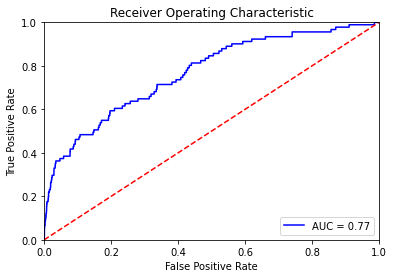

AUC score on train/test split: 0.7681533602732271


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Discretization 32 bins
[0.77561906 0.70972893 0.75898444 0.79379616 0.87344618 0.79177506
 0.82296597 0.81178378 0.76672379 0.79716689] Average AUC: 0.7902, STD: 0.0409


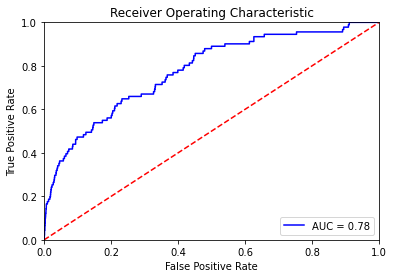

AUC score on train/test split: 0.7775630944332388


In [15]:
# --- This crashes! ---

# X_cop = X.copy()
# sc = StandardScaler()
# X_cop = sc.fit_transform(X_cop)
# print('StandardScaler')
# testModel(MultinomialNB(), X_cop, y)

# --- Discretization 32 bins is best! ---
X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
print('MinMaxScaler')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 2 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 4 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 8 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 16 bins')
testModel(MultinomialNB(), X_cop, y)

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
print('Discretization 32 bins')
testModel(MultinomialNB(), X_cop, y)

Multinomial Naive Bayes classifier best preprocessing = Discretization 16 bins (Average AUC: 0.81, STD: 0.0274, AUC score on train/test split: 0.801)

### Decision Tree classifier

[0.52481575 0.53763614 0.51184536 0.55086903 0.57737233 0.55094404
 0.55038152 0.5376016  0.53658635 0.51150773] Average AUC: 0.539, STD: 0.0189


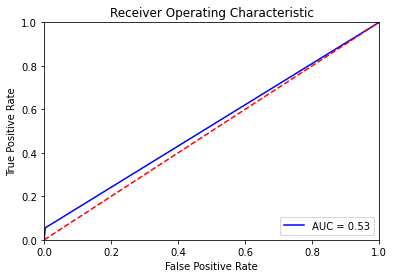

AUC score on train/test split: 0.525957694104198


In [16]:
# TODO: Investigate if we need to change data to fit model
testModel(DecisionTreeClassifier(), X, y)

### Random Forest classifier

[0.70777098 0.70895128 0.72784484 0.77673718 0.82643086 0.73134328
 0.71682055 0.7064999  0.67339811 0.75759944] Average AUC: 0.7333, STD: 0.0412


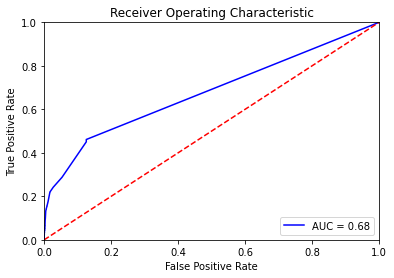

AUC score on train/test split: 0.6772773676214299


In [17]:
testModel(RandomForestClassifier(), X, y)

### Multi-layer Perceptron classifier

StandardScaler
[0.83386887 0.8505035  0.81977444 0.8464455  0.92949626 0.8974675
 0.85832343 0.87917395 0.78638056 0.82890197] Average AUC: 0.853, STD: 0.0388


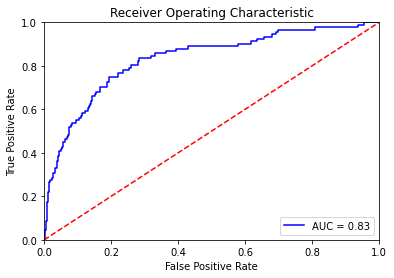

AUC score on train/test split: 0.8312883385025449


In [18]:
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
print('StandardScaler')
testModel(MLPClassifier(), X_cop, y)

# ---Not as good as StandardScaler!---

# X_cop = X.copy()
# sc = MinMaxScaler()
# X_cop = sc.fit_transform(X_cop)
# print('MinMaxScaler')
# testModel(MLPClassifier(), X_cop, y)

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=2, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization 2 bins')
# testModel(MLPClassifier(), X_cop, y)

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=4, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization 4 bins')
# testModel(MLPClassifier(), X_cop, y)

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=8, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization 8 bins')
# testModel(MLPClassifier(), X_cop, y)

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization 16 bins')
# testModel(MLPClassifier(), X_cop, y)

# X_cop = X.copy()
# kbd = KBinsDiscretizer(n_bins=32, encode="onehot")
# X_cop = kbd.fit_transform(X_cop)
# print('Discretization 32 bins')
# testModel(MLPClassifier(), X_cop, y)

## Conclusions of vanilla models:

| Model      | Kfold AUC Score | Kfold std | Train/test AUC Score | Best Preprocessing |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| Bernoulli Naive Bayes      | 0.7922       | 0.027       | 0.794       | Discretization 32 bins       |
| Gaussian Naive Bayes   | 0.7899       | 0.0291      | 0.790       | Standard Scaler       |
| Multinomial Naive Bayes      | 0.7922       | 0.027      | 0.794      | Discretization 32 bins       |
| Decision Tree   | 0.5285       | 0.0145      | 0.541       | No Preprocessing       |
| Random Forest   | 0.7324        | 0.0543       | 0.725       | No Preprocessing       |
| Multi-layer Perceptron   | 0.8453        | 0.0249       | 0.824       | Standard Scaler      |

We want to find the best parameters for the following models: Multi-layer Perceptron, Multinomial Naive Bayes and Random Forest

## Find best parameters

[0.84548824 0.79531199 0.81897705 0.84110655 0.91572947 0.88007694
 0.84416189 0.87332775 0.80498242 0.84962378] Average AUC: 0.8469, STD: 0.0343


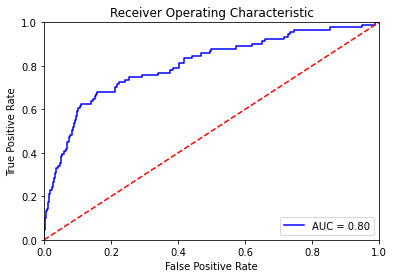

AUC score on train/test split: 0.8049525541201457


In [16]:
params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
testModel(MLPClassifier(**params), X_cop, y)

[0.8240831  0.8195297  0.77673225 0.84730802 0.93319603 0.86174293
 0.85634772 0.87197081 0.81049836 0.83984122] Average AUC: 0.8441, STD: 0.0398


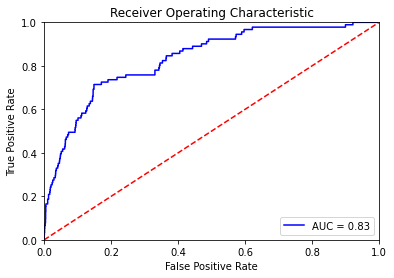

AUC score on train/test split: 0.8335567153547175


In [17]:
params = {'ccp_alpha': 0.0, 'class_weight': None, 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 400, 'oob_score': True}
testModel(RandomForestClassifier(**params), X, y)

### Multi-layer Perceptron classifier

Vanilla model
[0.83875584 0.79411788 0.82208174 0.84080852 0.93287135 0.88595274
 0.85511611 0.85911095 0.7858132  0.82730707] Average AUC: 0.8442, STD: 0.0408


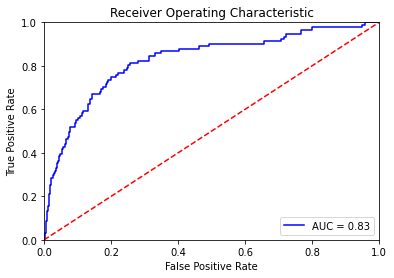

AUC score on train/test split: 0.8268577269687148


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\n

Tuned model with params: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
[0.85663589 0.81526249 0.82805623 0.86318276 0.91835059 0.8858284
 0.85828396 0.89078543 0.79237154 0.8274788 ] Average AUC: 0.8536, STD: 0.0365


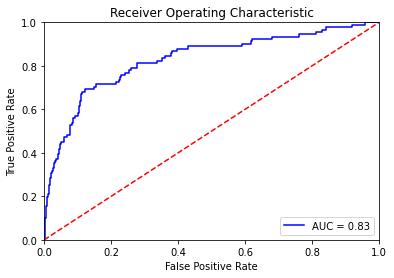

AUC score on train/test split: 0.8292765817738073


In [8]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['adaptive']
}

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
tuneModel(MLPClassifier(), params, X_cop, y)

Multi-layer Perceptron best params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

In [ ]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['adaptive']
}

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
tuneModel(MLPClassifier(), params, X_cop, y)

### Multinomial Naive Bayes classifier

C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature

Vanilla model
[0.77137356 0.71446293 0.75535474 0.78872761 0.86344527 0.79010923
 0.8123986  0.81652272 0.76143287 0.791339  ] Average AUC: 0.7865, STD: 0.0381


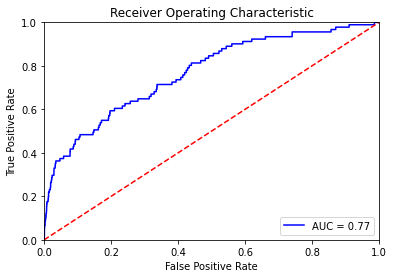

AUC score on train/test split: 0.7681533602732271
Tuned model with params: {'alpha': 0.1}
[0.77344993 0.71629258 0.7569811  0.7894125  0.86414595 0.79183822
 0.81275585 0.81788854 0.76184445 0.79262795] Average AUC: 0.7877, STD: 0.0379


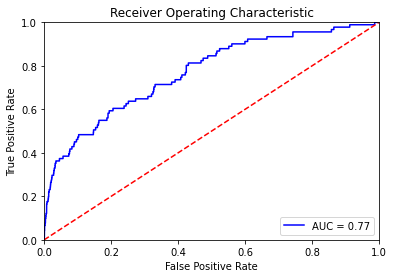

AUC score on train/test split: 0.7695826536004117


In [9]:
params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
}

X_cop = X.copy()
kbd = KBinsDiscretizer(n_bins=16, encode="onehot")
X_cop = kbd.fit_transform(X_cop)
tuneModel(MultinomialNB(), params, X_cop, y)

Guassian Naive Bayes best params = default

### Random Forest classifier

Vanilla model
[0.75643437 0.72868664 0.68824385 0.82822696 0.83895815 0.72149534
 0.77357033 0.68090946 0.71010082 0.73927294] Average AUC: 0.7466, STD: 0.0511


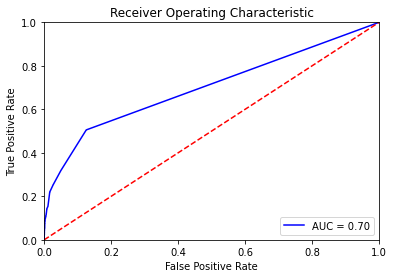

AUC score on train/test split: 0.7006174375763722
Tuned model with params: {'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 400, 'oob_score': True}
[0.85319962 0.83379288 0.79998283 0.82242221 0.92079605 0.89078148
 0.87887493 0.85769677 0.82364486 0.83116799] Average AUC: 0.8512, STD: 0.0348


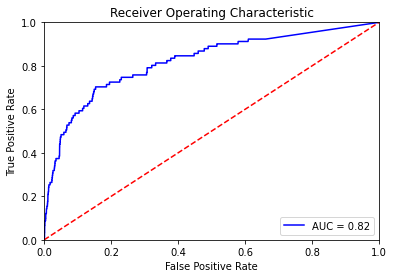

AUC score on train/test split: 0.8210232039310841


In [10]:
params = {
    'n_estimators': [50, 100, 400],
    'class_weight': ['balanced_subsample', None],
    'oob_score': [True],
    'min_samples_split': [2, 4, 6],
    'max_depth': [4, 8, 16],
    'ccp_alpha': [0.0, 0.05]
}

tuneModel(RandomForestClassifier(), params, X, y)

Vanilla model
[0.71294809 0.72132659 0.68983468 0.78947171 0.82065867 0.70211624
 0.78350314 0.67320597 0.75821909 0.72999274] Average AUC: 0.7381, STD: 0.0455


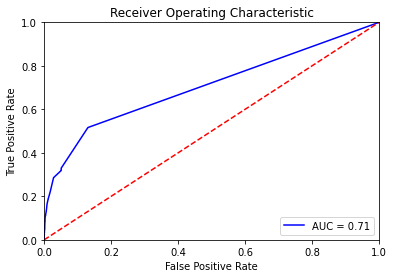

AUC score on train/test split: 0.7050811773342296
Tuned model with params: {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}
[0.85485756 0.85247723 0.79511955 0.81975766 0.92928606 0.87912954
 0.86586902 0.85480624 0.82234473 0.85023864] Average AUC: 0.8524, STD: 0.0347


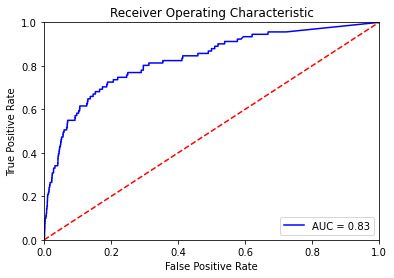

AUC score on train/test split: 0.8275151821211756


In [11]:
params = {
    'n_estimators': [200, 400, 600],
    'class_weight': ['balanced_subsample'],
    'oob_score': [True],
    'min_samples_split': [2, 4, 6],
    'max_depth': [16, 24, 32]
}

tuneModel(RandomForestClassifier(), params, X, y)

Vanilla model
[0.75050528 0.72106211 0.75399977 0.7740904  0.82122514 0.74689926
 0.74817035 0.67866039 0.71046816 0.68917484] Average AUC: 0.7394, STD: 0.0397


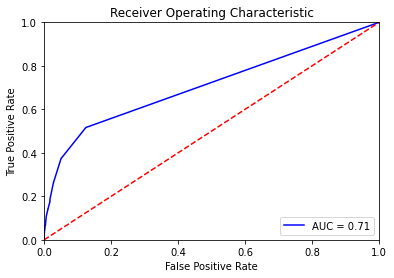

AUC score on train/test split: 0.7083926812006723
Tuned model with params: {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 800, 'oob_score': True}
[0.85253842 0.83900354 0.80024237 0.82723022 0.92907685 0.88595669
 0.88057629 0.86014815 0.82178795 0.8489418 ] Average AUC: 0.8546, STD: 0.0351


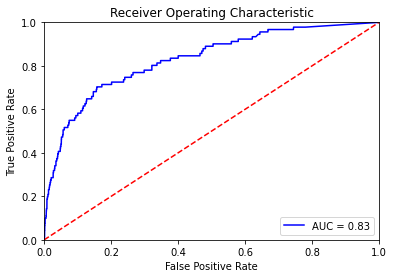

AUC score on train/test split: 0.8298326744497666


In [12]:
#Average AUC: 0.8532, STD: 0.0357

params = {
    'n_estimators': [600, 800],
    'class_weight': ['balanced_subsample'],
    'oob_score': [True],
    'min_samples_split': [4, 6, 8],
    'max_depth': [12, 16, 20]
}

tuneModel(RandomForestClassifier(), params, X, y)

Vanilla model
[0.7257211  0.73243772 0.71947029 0.80365792 0.85784283 0.74421104
 0.75042238 0.67459746 0.70084028 0.78299047] Average AUC: 0.7492, STD: 0.0506


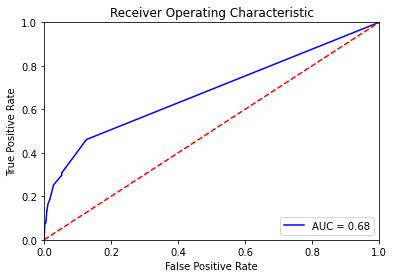

AUC score on train/test split: 0.6780429427488253
Tuned model with params: {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 1200, 'oob_score': True}
[0.85768986 0.8384953  0.80129043 0.83599656 0.92589321 0.88573168
 0.8809592  0.85724577 0.82579412 0.85433346] Average AUC: 0.8563, STD: 0.0332


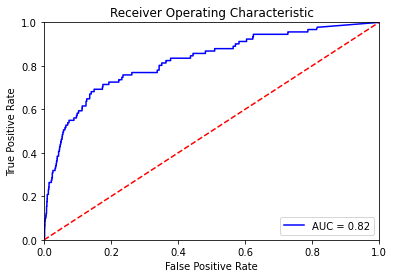

AUC score on train/test split: 0.8234615071463018


In [20]:
params = {
    'n_estimators': [900, 1000, 1200],
    'class_weight': ['balanced_subsample'],
    'oob_score': [True],
    'min_samples_split': [4],
    'max_depth': [16]
}

tuneModel(RandomForestClassifier(), params, X, y)

Vanilla model
[0.70006849 0.75187307 0.67482542 0.72275952 0.80586653 0.81116403
 0.78954276 0.70957892 0.72428685 0.71527054] Average AUC: 0.7405, STD: 0.0446


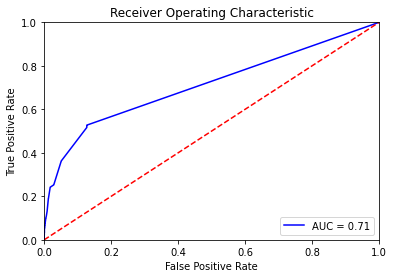

AUC score on train/test split: 0.7120608491307715


C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\CarbonXXX\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWa

In [24]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[ 
    ('rf', RandomForestClassifier()),
    ('mlp', MLPClassifier()),
    ], voting='soft')

print('Vanilla model')
testModel(eclf, X, y)

#Use the key for the classifier followed by __ and the attribute
params = {'rf__n_estimators': [400],
        'rf__min_samples_split': [4],
        'rf__max_depth': [10, 20],
        'mlp__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'mlp__activation': ['tanh', 'relu'],
        'mlp__solver': ['sgd', 'adam'],
        'mlp__alpha': [0.0001, 0.005],
        'mlp__learning_rate': ['adaptive'],}

strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=eclf, param_grid=params, cv=strat_k_fold, scoring='roc_auc')
grid_search.fit(X, y)
best_params = grid_search.best_params_
eclf.set_params(**best_params)
print('Tuned model with params: ' + str(best_params))
testModel(eclf, X, y)

[0.8470396  0.84173025 0.79311029 0.83716698 0.92806037 0.88782384
 0.87165304 0.8633831  0.82654035 0.84832102] Average AUC: 0.8545, STD: 0.0346


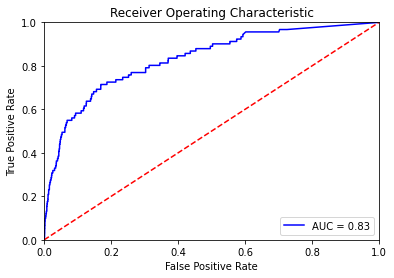

AUC score on train/test split: 0.8320669341757023


In [15]:
params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}

testModel(RandomForestClassifier(**params, random_state=42), X, y)

[0.84724289 0.84316516 0.7841377  0.83291556 0.92052861 0.88470139
 0.87306327 0.86914245 0.80899628 0.8596284 ] Average AUC: 0.8524, STD: 0.0367


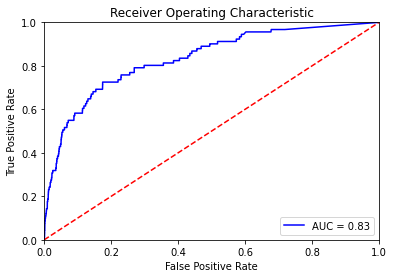

AUC score on train/test split: 0.8332158737264176


In [17]:
params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)
testModel(RandomForestClassifier(**params, random_state=42), X_cop, y)

[0.84821101 0.83963218 0.80201479 0.83331228 0.92748799 0.88528365
 0.87763148 0.8649986  0.82090517 0.85544179] Average AUC: 0.8555, STD: 0.0339


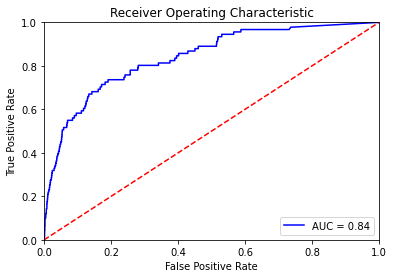

AUC score on train/test split: 0.8397566377588576


In [16]:
params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)
testModel(RandomForestClassifier(**params, random_state=42), X_cop, y)

[0.86760195 0.8531483  0.79492711 0.83151125 0.92740608 0.88305037
 0.87357447 0.86604961 0.83211398 0.84375543] Average AUC: 0.8573, STD: 0.0338


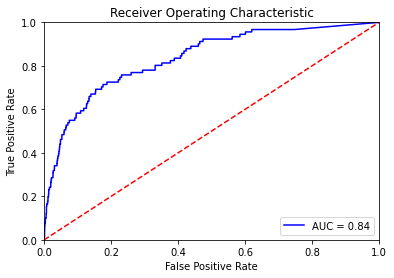

AUC score on train/test split: 0.8353939308434314


In [9]:
from sklearn.ensemble import VotingClassifier

X_cop = X.copy()
sc = StandardScaler()
X_cop = sc.fit_transform(X_cop)

rf_params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}
mlp_params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

eclf = VotingClassifier(estimators=[ 
    ('rf', RandomForestClassifier(**rf_params)),
    ('mlp', MLPClassifier(**mlp_params)),
    ], voting='soft')

testModel(eclf, X, y)

[0.84885642 0.82681771 0.80142267 0.83611103 0.92151251 0.88786924
 0.88115459 0.85088344 0.81940502 0.857391  ] Average AUC: 0.8531, STD: 0.0339


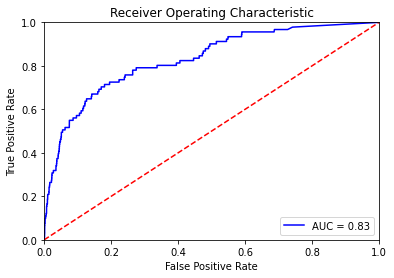

AUC score on train/test split: 0.8308385528141354


In [10]:
from sklearn.ensemble import VotingClassifier

X_cop = X.copy()
sc = MinMaxScaler()
X_cop = sc.fit_transform(X_cop)

rf_params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}
mlp_params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

eclf = VotingClassifier(estimators=[ 
    ('rf', RandomForestClassifier(**rf_params)),
    ('mlp', MLPClassifier(**mlp_params)),
    ], voting='soft')

testModel(eclf, X, y)